## Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.

In [1]:
import pandas as pd
import datetime
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from typing import List, Tuple

import missingno as msno

from catboost import CatBoostClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')


pd.options.display.max_rows=100
pd.options.display.max_columns=400

In [2]:
train = pd.read_csv('assignment_train.csv')
test = pd.read_csv('assignment_test.csv')

### Обзор данных

In [3]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
test.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,aol.com,NaN,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,50.0,2.0,104.0,104.0,0.0,317.0,0.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,M1,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,43.0,22.0,4.0,40.0,20.0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,194.0,2168.0,1139.0,194.0,1965.5,991.0,0.0,202.5,148.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,20.0,0.0,0.0,0.0,4.0,44.0,0.0,20.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,194.0,2172.0,991.0,194.0,2172.0,0.0,991.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,debit,325.0,87.0,55.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


В тестовых данных признаков, в которых присутствуют пропуски, гораздо больше.

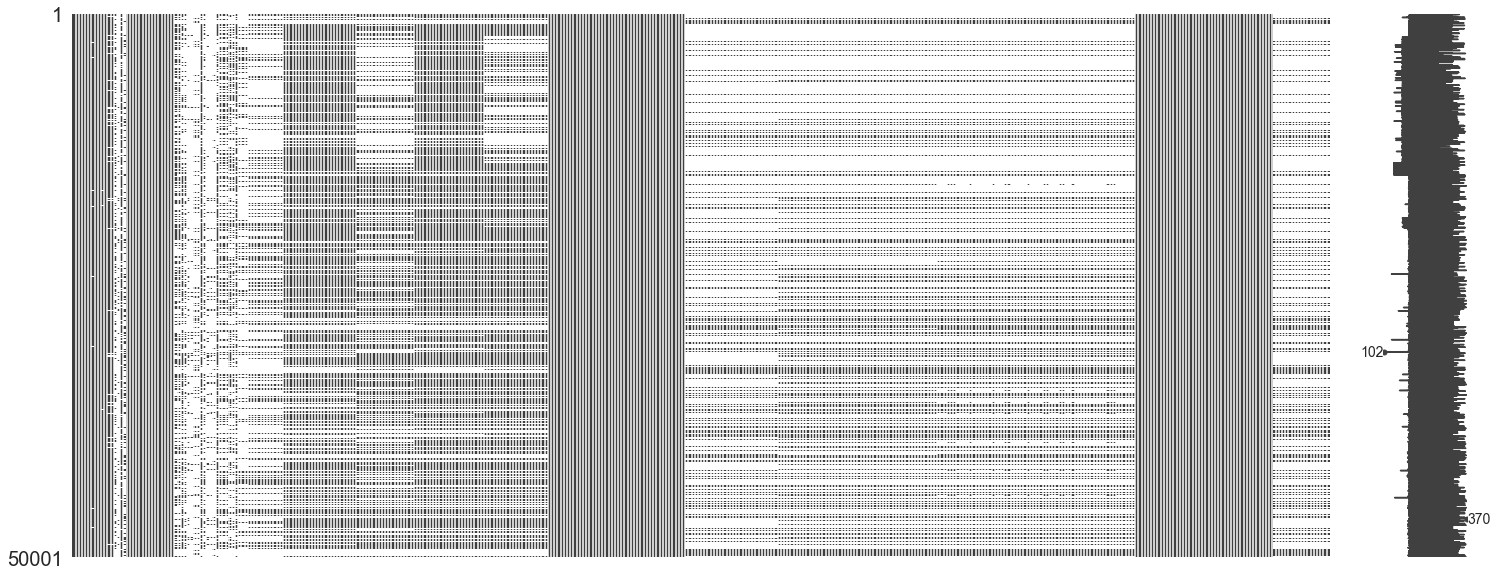

In [7]:
msno.matrix(train);

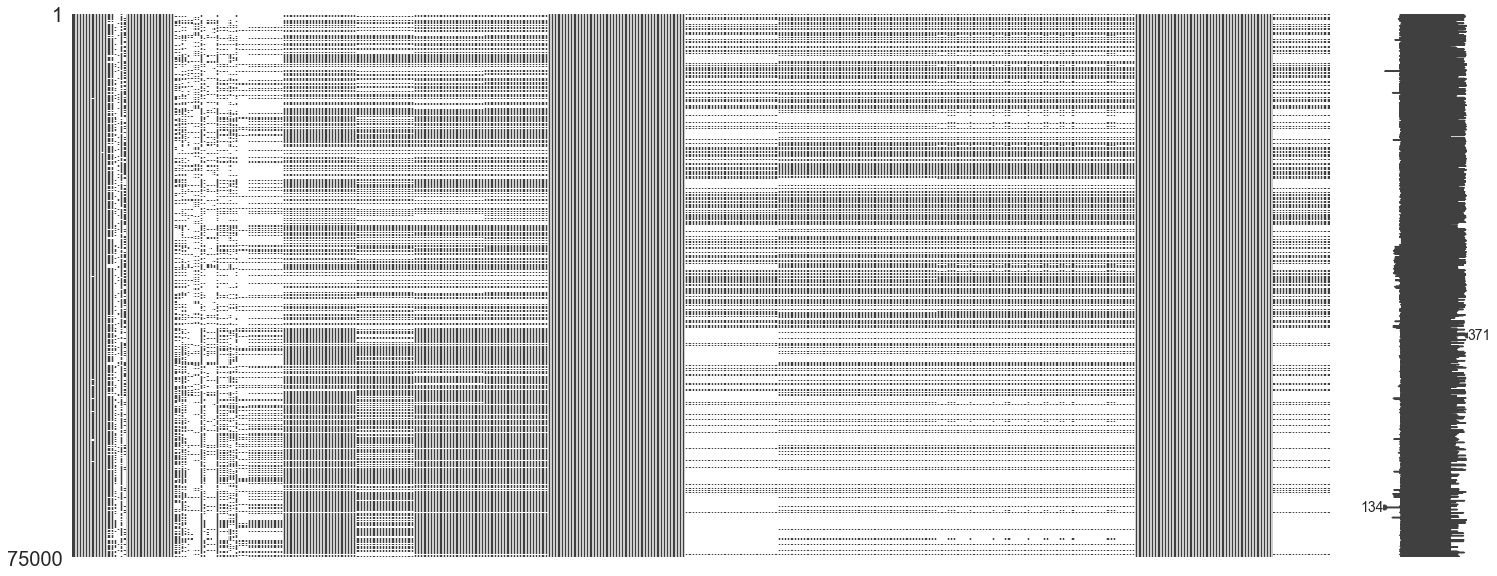

In [8]:
msno.matrix(test);

Пропуски в трейне и тесте распределены по-разному, скорее всего, признаки с большим количеством пропуском - кандидаты на удаление.

In [9]:
features_with_gaps = train.columns[train.isnull().sum() / len(train) * 100 > 50].tolist()
len(features_with_gaps)

192

In [10]:
train = train.drop(columns=features_with_gaps)
test = test.drop(columns=features_with_gaps)

### Построение списков признаков

#### Количественные признаки

In [11]:
quantitative_features = train.select_dtypes('int64').drop(columns=['TransactionID', 'isFraud']).columns.tolist()
quantitative_features

['TransactionDT', 'card1']

In [12]:
round((
    len(train[quantitative_features]) - train[quantitative_features].count()) / 
    len(train[quantitative_features]) * 100, 2).sort_values(ascending=False)

card1            0.0
TransactionDT    0.0
dtype: float64

In [13]:
train[quantitative_features].nunique().sort_values()

card1             5446
TransactionDT    48346
dtype: int64

Количественные признаки не имеют пропусков. Но TransactionDT - это время транзакции, удалим этом признак из модели.

In [14]:
quantitative_features = ['card1']

#### Категориальные признаки

In [15]:
cat_features = train.select_dtypes('object').columns.tolist()
cat_features

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [16]:
round((len(train[cat_features]) - train[cat_features].count()) / len(train[cat_features]) * 100, 2).sort_values(ascending=False)

M6               37.34
P_emaildomain    17.97
card6             0.01
card4             0.01
ProductCD         0.00
dtype: float64

In [17]:
train[cat_features].nunique().sort_values()

M6                2
card4             4
card6             4
ProductCD         5
P_emaildomain    59
dtype: int64

Для пропущенных значений создадим отдельную категорию.

In [18]:
train['M6'].value_counts(), train['M6'].isnull().sum()

(F    17030
 T    14300
 Name: M6, dtype: int64,
 18671)

In [19]:
train['M6'].fillna(-1, inplace=True)
train.loc[train['M6'] == 'T', 'M6'] = 1
train.loc[train['M6'] == 'F', 'M6'] = 0

In [20]:
test['M6'].fillna(-1, inplace=True)
test.loc[test['M6'] == 'T', 'M6'] = 1
test.loc[test['M6'] == 'F', 'M6'] = 0

In [21]:
train['P_emaildomain'].value_counts(), train['P_emaildomain'].isnull().sum()

(gmail.com           17910
 yahoo.com            8360
 hotmail.com          3728
 anonymous.com        3466
 aol.com              2443
 comcast.net           849
 icloud.com            468
 msn.com               387
 outlook.com           360
 att.net               326
 sbcglobal.net         307
 verizon.net           288
 live.com              247
 ymail.com             184
 bellsouth.net         182
 cox.net               157
 charter.net           141
 me.com                134
 yahoo.com.mx          126
 optonline.net         104
 live.com.mx            71
 rocketmail.com         59
 earthlink.net          55
 gmail                  41
 mail.com               38
 roadrunner.com         38
 mac.com                37
 embarqmail.com         33
 juno.com               33
 windstream.net         32
 twc.com                30
 web.de                 29
 frontier.com           28
 frontiernet.net        24
 cfl.rr.com             24
 netzero.com            24
 outlook.es             23
 

Сократим количество категорий у этого признака, объединив в одну те, что содержат меньше 3000 вхождений.

In [22]:
train.loc[~
    ((train['P_emaildomain'] == 'gmail.com') | 
    (train['P_emaildomain'] == 'yahoo.com') | 
    (train['P_emaildomain'] == 'hotmail.com') | 
    (train['P_emaildomain'] == 'anonymous.com')), 'P_emaildomain'] = 'other'

In [23]:
test.loc[~
    ((test['P_emaildomain'] == 'gmail.com') | 
    (test['P_emaildomain'] == 'yahoo.com') | 
    (test['P_emaildomain'] == 'hotmail.com') | 
    (test['P_emaildomain'] == 'anonymous.com')), 'P_emaildomain'] = 'other'

In [24]:
train['P_emaildomain'].fillna('missing', inplace=True)
test['P_emaildomain'].fillna('missing', inplace=True)

In [25]:
train['P_emaildomain'].value_counts()

gmail.com        17910
other            16537
yahoo.com         8360
hotmail.com       3728
anonymous.com     3466
Name: P_emaildomain, dtype: int64

#### Вещественные признаки

In [26]:
float_features = train.select_dtypes('float64').columns.tolist()
len(float_features)

193

Признаков, которые принимают вещественные значения, очень много, посмотрим на них внимательнее, возможно, не все признаки вещественные.

In [27]:
train_nunique = train[float_features].apply(lambda x: x.nunique(dropna=False))
train_nunique.shape

(193,)

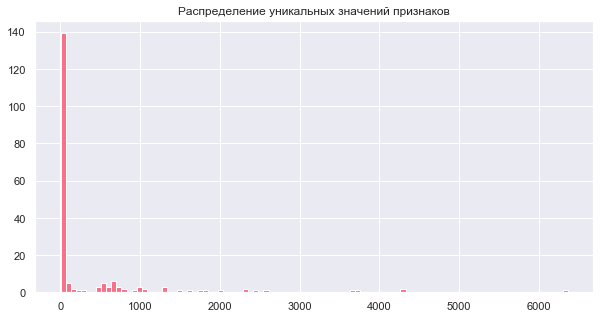

In [28]:
plt.title("Распределение уникальных значений признаков");
train_nunique.hist(bins=100, figsize=(10, 5));

In [29]:
all_features = set(train_nunique.index.tolist())
len(all_features)

193

#### Константные признаки

In [30]:
const_features = set(train_nunique[train_nunique == 1].index.tolist())
const_features

{'V107'}

In [31]:
train.loc[:5, 'V107'], test.loc[:5, 'V107']

(0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64,
 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64)

In [32]:
train['V107'].isnull().sum()

0

Константный признак не будем использовать для модели.

#### Вещественные признаки

In [33]:
numeric_features = (train[float_features].fillna(0).astype(int).sum() - train[float_features].fillna(0).sum()).abs()
numeric_features = set(numeric_features[numeric_features > 0].index.tolist())
len(numeric_features)

29

In [34]:
other = all_features - (numeric_features | const_features)
len(other)

163

#### Бинарные

In [35]:
binary_features = set(train[float_features].loc[:, other].columns[(
                      (train[float_features].loc[:, other].max() == 1) & \
                      (train[float_features].loc[:, other].min() == 0) & \
                      (train[float_features].loc[:, other].isnull().sum() == 0))])
len(binary_features)

0

Бинарных признаков нет.

In [36]:
numeric_features = numeric_features | other

In [37]:
other = other - numeric_features
len(other)

0

Таким образом мы выделили четыре типа данных в наших выборках: целочисленные, категориальные, вещественые и один константный.

In [38]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 202 entries, TransactionID to V321
dtypes: float64(193), int64(5), object(4)
memory usage: 77.1+ MB


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 202 entries, TransactionID to V321
dtypes: float64(193), int64(5), object(4)
memory usage: 115.6+ MB


Если будете решать ДЗ на отдельном датасете (не датасет из соревнования) - то использовать датасет из ДЗ2, IEEE-Fraud-Detection Challenge.

### Задание 0: 
выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [53]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

def prepare_data(X, categorical, to_drop):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed

to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]

categorical = train.select_dtypes(include=["object"]).columns.tolist()

x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_public_lb.shape))

cb_params_1000 = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

x_train.shape = 35000 rows, 199 cols
x_valid.shape = 15001 rows, 199 cols
x_test.shape = 75000 rows, 199 cols
0:	test: 0.6515258	best: 0.6515258 (0)	total: 58.6ms	remaining: 1m 57s
10:	test: 0.7592730	best: 0.7592730 (10)	total: 522ms	remaining: 1m 34s
20:	test: 0.7832676	best: 0.7856442 (18)	total: 959ms	remaining: 1m 30s
30:	test: 0.7981113	best: 0.7985792 (28)	total: 1.4s	remaining: 1m 28s
40:	test: 0.8018721	best: 0.8031421 (37)	total: 1.83s	remaining: 1m 27s
50:	test: 0.8122854	best: 0.8132879 (48)	total: 2.27s	remaining: 1m 26s
60:	test: 0.8135209	best: 0.8145212 (53)	total: 2.71s	remaining: 1m 26s
70:	test: 0.8187845	best: 0.8194629 (68)	total: 3.15s	remaining: 1m 25s
80:	test: 0.8238431	best: 0.8238431 (80)	total: 3.59s	remaining: 1m 25s
90:	test: 0.8257408	best: 0.8259125 (86)	total: 4.03s	remaining: 1m 24s
100:	test: 0.8353597	best: 0.8353597 (100)	total: 4.47s	remaining: 1m 24s
110:	test: 0.8410125	best: 0.8410125 (110)	total: 4.91s	remaining: 1m 23s
120:	test: 0.8456779	bes

1110:	test: 0.8943588	best: 0.8943588 (1110)	total: 49.4s	remaining: 39.5s
1120:	test: 0.8944419	best: 0.8944419 (1120)	total: 49.9s	remaining: 39.1s
1130:	test: 0.8946418	best: 0.8946418 (1130)	total: 50.3s	remaining: 38.6s
1140:	test: 0.8949596	best: 0.8949596 (1140)	total: 50.7s	remaining: 38.2s
1150:	test: 0.8952119	best: 0.8952119 (1150)	total: 51.1s	remaining: 37.7s
1160:	test: 0.8953298	best: 0.8953298 (1160)	total: 51.6s	remaining: 37.3s
1170:	test: 0.8953933	best: 0.8953933 (1170)	total: 52s	remaining: 36.8s
1180:	test: 0.8955175	best: 0.8955175 (1180)	total: 52.5s	remaining: 36.4s
1190:	test: 0.8957121	best: 0.8957121 (1190)	total: 52.9s	remaining: 35.9s
1200:	test: 0.8957354	best: 0.8957354 (1200)	total: 53.3s	remaining: 35.5s
1210:	test: 0.8958638	best: 0.8958638 (1210)	total: 53.8s	remaining: 35s
1220:	test: 0.8959927	best: 0.8959927 (1220)	total: 54.3s	remaining: 34.6s
1230:	test: 0.8960038	best: 0.8960038 (1229)	total: 54.8s	remaining: 34.2s
1240:	test: 0.8960292	best: 0

### Задание 1: 
признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [54]:
import datetime

# Дальше не успела, сделаю в бл время

### Задание 2: 
сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

### Задание 3:
преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

### Задание 4: 
преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

### Задание 5: 
для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

### Задание 6: 
использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

### Задание 7: 
(опциональное) испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.